# 使用迁移学习在pytorch中实现图像识别


In [1]:
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import time
import torch
import numpy as np


# Applying transforms to data.
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)), 
        transforms.RandomRotation(degrees=15), 
        transforms.RandomHorizontalFlip(), 
        transforms.CenterCrop(size=224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]), 
    
    'valid': transforms.Compose([
        transforms.Resize(size=256), 
        transforms.CenterCrop(size=224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]), 
    
    'test': transforms.Compose([
        transforms.Resize(size=256), 
        transforms.CenterCrop(size=224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]), 
}

In [2]:
# Load dataset
train_dir = './raw/caltech256_animalsubset/train'
valid_dir = './raw/caltech256_animalsubset/valid'
test_dir = './raw/caltech256_animalsubset/test'

bs = 32         # batch size

data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']), 
    
    'valid': datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid']), 
    
    'test': datasets.ImageFolder(root=test_dir, transform=image_transforms['test']), 
}

train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create dataloader
train_dataloader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_dataloader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_dataloader = DataLoader(data['test'], batch_size=bs, shuffle=True)

print(train_data_size, valid_data_size, test_data_size)

600 100 409


In [3]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

from torchinfo import summary
summary(resnet50, input_size=[bs, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [4]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_input = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_input, 256), 
    nn.ReLU(), 
    nn.Dropout(0.4), 
    nn.Linear(256, 10), 
    nn.LogSoftmax(dim=1)
)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)


def train_loop(dataloader, model, loss_fn, optimizer, displaystep=0.1):  
    data_size = len(dataloader.dataset) 
    disp_step = np.floor(data_size*displaystep).astype(np.int32)
    
    # Set to training mode
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # display progress
        if batch % disp_step == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}, [{current:>d}]/[{data_size:>d}]")
            
            
def valid_loop(dataloader, model, loss_fn):
    
    # Set to evaluation mode
    model.eval()
    
    data_size = len(dataloader.dataset)
    valid_loss, correct = 0, 0
    
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float64).sum().item()
    
    valid_loss /= data_size
    correct /= data_size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f}\n")
        
        
# Start trainning
epochs = 30
for epoch in range(epochs):
    epoch_start = time.time()
    print(f"Epoch: {epoch+1}/{epochs}\n------------------------------------------")
    train_loop(train_dataloader, resnet50, loss_func, optimizer)
    valid_loop(valid_dataloader, resnet50, loss_func)
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    print(f"Epoch time: {epoch_time:>.4f}")

Epoch: 1/30
------------------------------------------
loss: 2.313957, [0]/[600]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.025205

Epoch time: 127.2826
Epoch: 2/30
------------------------------------------
loss: 0.626574, [0]/[600]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.012523

Epoch time: 116.8682
Epoch: 3/30
------------------------------------------
loss: 0.342232, [0]/[600]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.009719

Epoch time: 109.7473
Epoch: 4/30
------------------------------------------
loss: 0.257834, [0]/[600]
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.006120

Epoch time: 103.0402
Epoch: 5/30
------------------------------------------
loss: 0.091491, [0]/[600]
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.012059

Epoch time: 102.7553
Epoch: 6/30
------------------------------------------
loss: 0.191347, [0]/[600]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.005468

Epoch time: 116.6603
Epoch: 7/30
------------------------------------------
loss: 0.189961, [0]/[600]
T

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
import os

animals = os.listdir('./raw/caltech256_animalsubset/train')
idx = list(range(len(animals)))
idx_to_class = dict(zip(idx, animals))


def predict(model, test_img_name):
    transform = image_transforms['test']
    test_img = Image.open(test_img_name)
    plt.imshow(test_img)
    test_img_tensor = (transform(test_img)).view(1, 3, 224, 224)
    with torch.no_grad():
        model.eval()
        out = model(test_img_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        print("Output class: ", idx_to_class[topclass.numpy()[0][0]])    

Output class:  ostrich


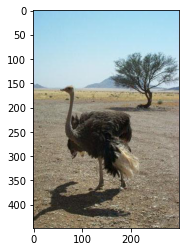

In [21]:
test_img = './raw/caltech256_animalsubset/test/ostrich/151_0084.jpg'
predict(resnet50, test_img)